<a href="https://colab.research.google.com/github/ChiriKamau/limaAI/blob/main/notebooks/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:

from google.colab import drive
drive.mount('/content/drive')


!pip install ultralytics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import Image as IPImage, display
import cv2
import os
import numpy as np

In [15]:

yolo_model_path = '/content/drive/MyDrive/Tomato_dataset/models/yolov8m_trained.pt'
yolo_model = YOLO(yolo_model_path)
ripe_model = load_model('/content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet(v3)/ripe_mobilenet(v3.3).keras')
green_model = load_model('/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v3)/green_mobilenet(v3.4).keras')

ripe_class_names = ['R_healthy', 'R_ber', 'R_spots']
green_class_names = ['G_healthy', 'G_lateblight', 'G_ber', 'G_spots']

test_images = ['/content/drive/MyDrive/Tomato_dataset/Yolo_images/phone1(ripe)/IMG_20250904_144253.jpg']


image 1/1 /content/drive/MyDrive/Tomato_dataset/Yolo_images/phone1(ripe)/IMG_20250904_144253.jpg: 320x256 6 greens, 2 ripes, 344.1ms
Speed: 2.6ms preprocess, 344.1ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 256)


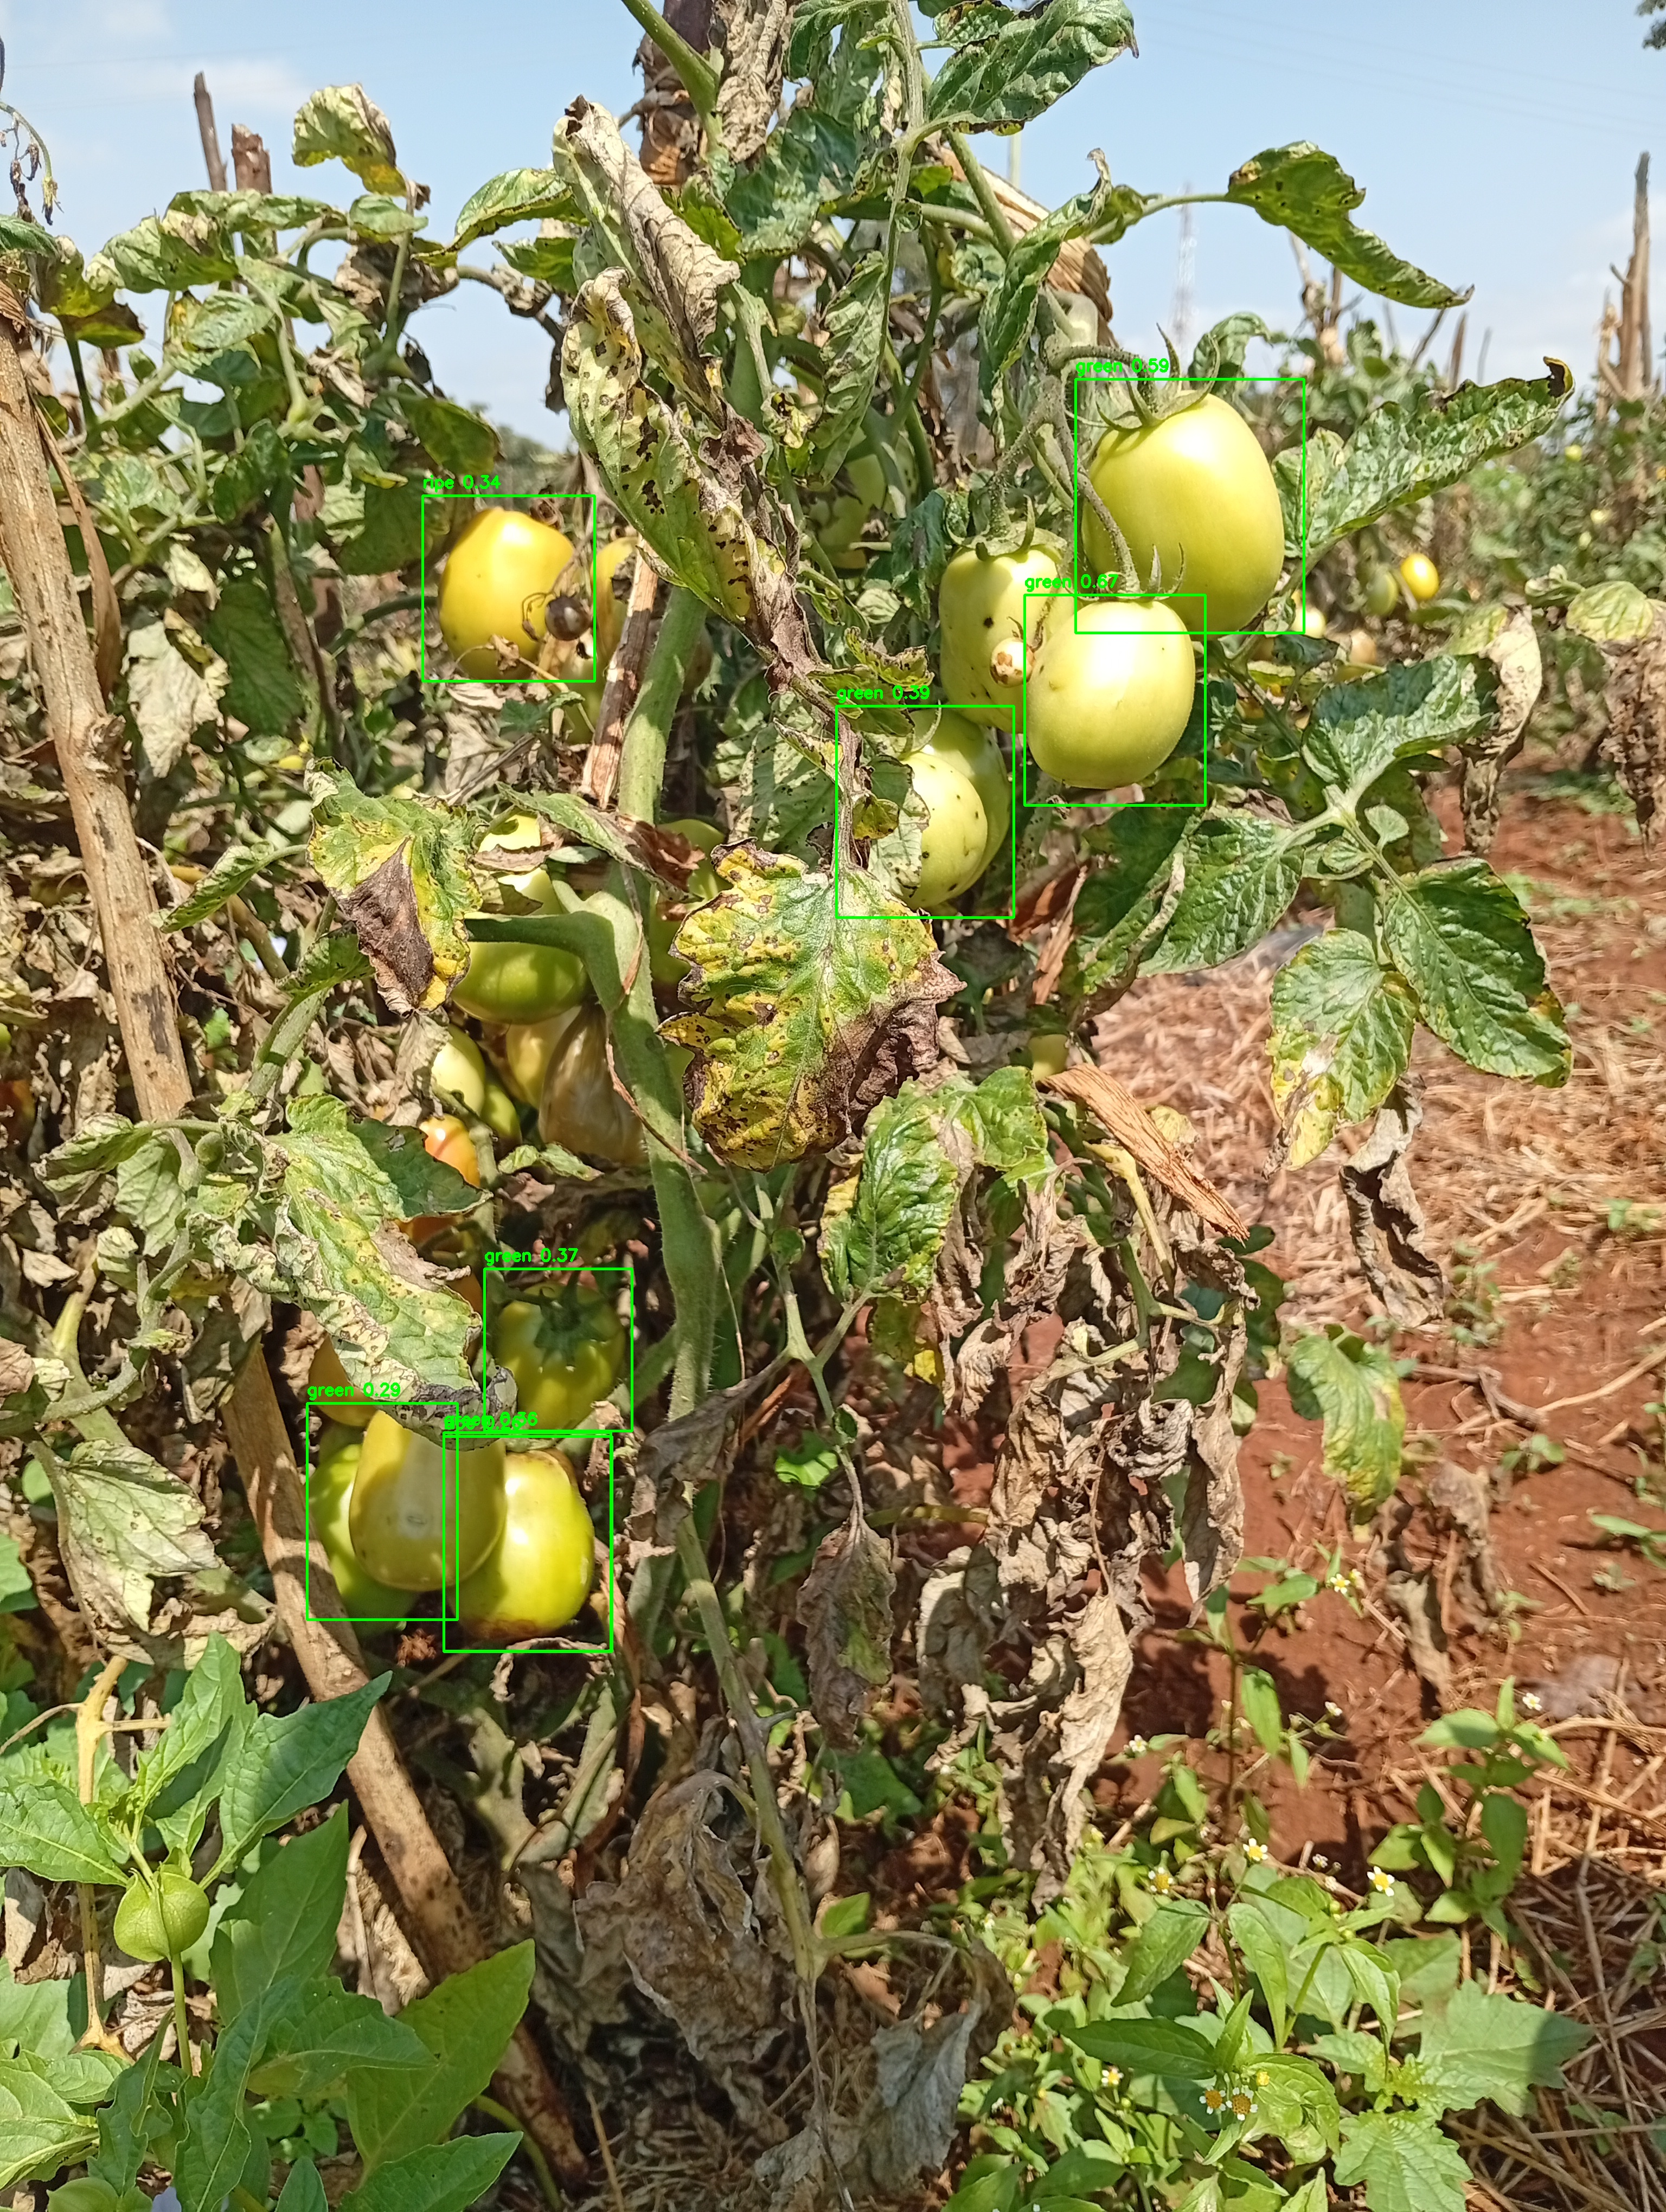

Found 8 tomatoes


In [16]:

import cv2
from IPython.display import Image as IPImage, display
import os

img_path = test_images[0]
results = yolo_model(img_path)
img = cv2.imread(img_path)
boxes = []

for r in results:
    for box in r.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        label = yolo_model.names[int(box.cls[0])]
        conf = float(box.conf[0])
        color = (0,0,255) if label=='R' else (0,255,0)
        cv2.rectangle(img, (x1,y1),(x2,y2), color, 3)
        cv2.putText(img, f"{label} {conf:.2f}", (x1,y1-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)
        boxes.append({'x1':x1,'y1':y1,'x2':x2,'y2':y2,'label':label})

cv2.imwrite('/content/yolo.jpg', img)
display(IPImage('/content/yolo.jpg'))
print(f"Found {len(boxes)} tomatoes")

In [17]:

img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)
crops = []
os.makedirs('/content/crops', exist_ok=True)

for i, box in enumerate(boxes):
    crop = img[box['y1']:box['y2'], box['x1']:box['x2']]
    crop_path = f'/content/crops/crop_{i+1}_{box["label"]}.jpg'
    cv2.imwrite(crop_path, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
    crops.append({'path':crop_path, **box, 'id':i+1})

print(f"Cropped {len(crops)} tomatoes")

Cropped 8 tomatoes


In [ ]:

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

final_img = cv2.imread(img_path)
for crop in crops:
    crop_img = cv2.imread(crop['path'])
    crop_resized = cv2.resize(crop_img, (256,256))

    crop_array = np.expand_dims(crop_resized.astype(np.float32)/255.0, 0)

    if crop['label']=='R':
        pred = ripe_model.predict(crop_array, verbose=0)[0]
        class_names = ripe_class_names
    else:
        pred = green_model.predict(crop_array, verbose=0)[0]
        class_names = green_class_names

    keras_class = class_names[np.argmax(pred)]
    keras_conf = float(np.max(pred))

    color = (0,0,255) if keras_class in ['R_healthy', 'R_ber'] else (0,255,0)

    x1,y1,x2,y2 = crop['x1'], crop['y1'], crop['x2'], crop['y2']
    cv2.rectangle(final_img, (x1,y1),(x2,y2), color, 3)
    cv2.putText(final_img, f"{crop['label']}→{keras_class}({keras_conf:.2f})",
                (x1,y1-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

cv2.imwrite('/content/FINAL.jpg', final_img)
display(IPImage('/content/FINAL.jpg'))
print(" DONE!")